In [1]:
from src.baseline_model import train_svm_model
from src.vectorization import vectorize_text
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("Data/imdb_cleaned.csv")

In [2]:
X, y, _ = vectorize_text(df, use_er_score=False)
model_tfidf, report_tfidf, confusion_tfidf, acc_tfidf = train_svm_model(X, y)

print("Accuracy (TF-IDF only):", acc_tfidf)

Accuracy (TF-IDF only): 0.8931


In [3]:
X_er, y, vectorizer = vectorize_text(df, use_er_score=True)
model_er, report_er, confusion_er, acc_er = train_svm_model(X_er, y)

print("Accuracy (TF-IDF + ER score):", acc_er)

Accuracy (TF-IDF + ER score): 0.8963


On observe un gain mesurable (+0.32 points) en ajoutant le score de polarit√© er_score. Ce gain reste modeste mais robuste, surtout que l‚Äôajout ne demande aucun entra√Ænement suppl√©mentaire.

Le score er_score apporte une information affective globale que TF-IDF ne capture pas toujours (surtout si certains mots sont rares mais tr√®s connot√©s).

Le mod√®le a donc l√©g√®rement mieux distingu√© certaines reviews ambigu√´s ou marginales.

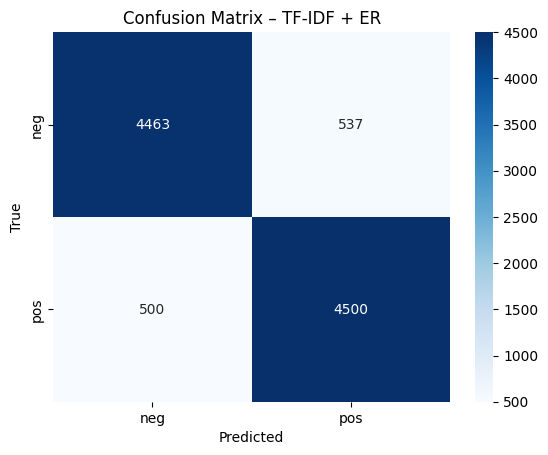

In [4]:
sns.heatmap(confusion_er, annot=True, fmt="d", cmap="Blues", xticklabels=["neg", "pos"], yticklabels=["neg", "pos"])
plt.title("Confusion Matrix ‚Äì TF-IDF + ER")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Faux positifs : 537 
Faux n√©gatifs : 500
Le mod√®le est tr√®s √©quilibr√© (presque sym√©trique), ce qui est un bon signe.

L‚Äôint√©gration du score er_score est donc justifi√©e empiriquement, utile √† moindre co√ªt avec une valeur ajout√©e claire √† int√©grer dans l'article final

In [5]:
# R√©cup√©rer le vocabulaire et les poids du mod√®le (en excluant er_score)
feature_names = vectorizer.get_feature_names_out()
coef = model_er.coef_[0][:-1]  # On enl√®ve le dernier coeff = er_score

# DataFrame pour analyse
coef_df = pd.DataFrame({
    "word": feature_names,
    "weight": coef
})

# Mots les plus indicateurs
top_pos = coef_df.sort_values(by="weight", ascending=False).head(20)
top_neg = coef_df.sort_values(by="weight").head(20)

c:\Users\pc\python-exercises-the-demby\env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


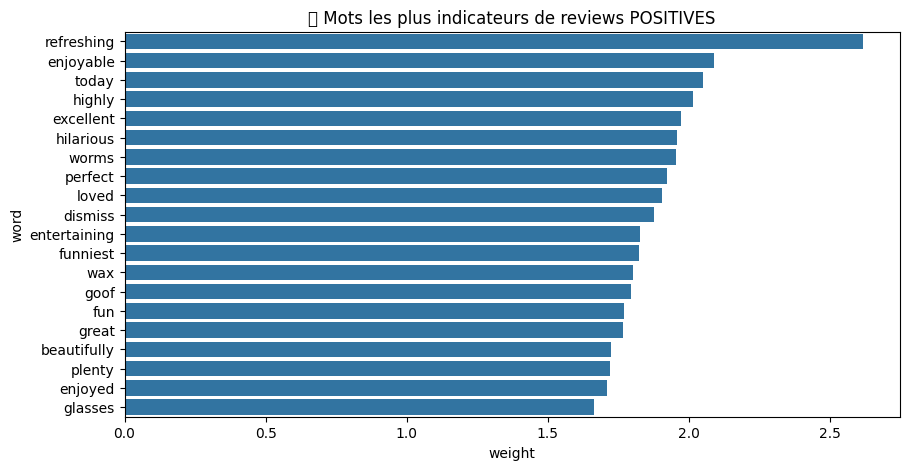

c:\Users\pc\python-exercises-the-demby\env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


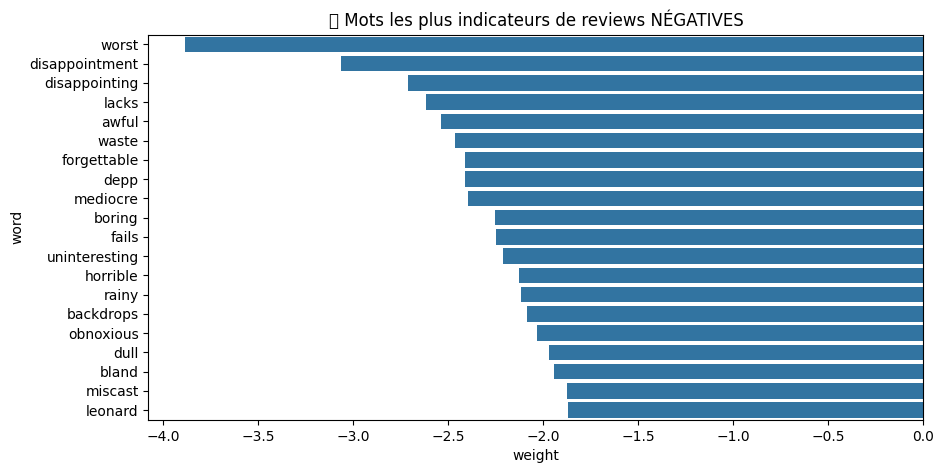

In [6]:
plt.figure(figsize=(10,5))
sns.barplot(x="weight", y="word", data=top_pos)
plt.title("üîµ Mots les plus indicateurs de reviews POSITIVES")
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(x="weight", y="word", data=top_neg)
plt.title("üî¥ Mots les plus indicateurs de reviews N√âGATIVES")
plt.show()

In [7]:
from sklearn.model_selection import train_test_split
X_er, y, vectorizer = vectorize_text(df, use_er_score=True)
X_train, X_test, y_train, y_test = train_test_split(
    X_er, y, test_size=0.2, random_state=42, stratify=y
)

# Pr√©dictions
y_pred = model_er.predict(X_test)

# R√©cup√©rer les indices mal class√©s
misclassified_idx = (y_test != y_pred)

# Reconstituer les reviews mal class√©es (index r√©align√© avec df original)
df_test = df.iloc[y_test.index] if isinstance(y_test, pd.Series) else df.iloc[y_test.tolist()]
misclassified_df = df_test[misclassified_idx]

# Affichage lisible complet des reviews
for i, row in misclassified_df.sample(3, random_state=72).iterrows():
    print(f"üîª Label r√©el : {'POSITIVE' if row['label'] == 1 else 'NEGATIVE'}")
    print(f"üî∫ Pr√©diction : {'POSITIVE' if 1 - row['label'] == 1 else 'NEGATIVE'}")
    print(f"üß† Score ER moyen : {row['er_score']:.3f}")
    print("üìù Review nettoy√©e :\n")
    print(row['cleaned_text'])
    print("-" * 100)

üîª Label r√©el : POSITIVE
üî∫ Pr√©diction : NEGATIVE
üß† Score ER moyen : 0.091
üìù Review nettoy√©e :

homelessness houselessness george carlin stated issue years never plan help street considered human everything going school work vote matter people think homeless lost cause worrying things racism war iraq pressuring kids succeed technology elections inflation worrying next end streets given bet live streets month without luxuries home entertainment sets bathroom pictures wall computer everything treasure see like homeless goddard bolt lesson mel brooks directs stars bolt plays rich man everything world deciding make bet sissy rival jeffery tambor see live streets thirty days without luxuries bolt succeeds wants future project making buildings bet bolt thrown street bracelet leg monitor every move ca step sidewalk given nickname pepto vagrant written forehead bolt meets characters including woman name molly lesley ann warren got divorce losing home pals sailor howard morris fume

Pour la premiere review mal class√©e :Il s‚Äôagit d‚Äôun commentaire positif mais tr√®s subtil sur un film de Mel Brooks. La critique d√©fend le message social du film (homelessness, humanit√©), et ne contient presque aucun mot explicitement positif. Elle √©voque des th√®mes durs : "street", "homeless", "lost cause", "war", etc.

Le mod√®le se base fortement sur le lexique et les mots cl√©s. Ici, le ton est positif dans l‚Äôintention, mais les mots sont neutres ou m√™me n√©gatifs lexicalement. Le score ER est bas (0.091), ce qui refl√®te l‚Äôabsence de mots affectivement marqu√©s.

üí°En conclusion, le mod√®le √©choue quand le sentiment est implicite, non exprim√© par un vocabulaire √©motionnel √©vident.

Pour la seconde review mal class√©e :Une satire sur le syst√®me scolaire est d√©crite. Ton tr√®s ironique, vocabulaire critique sur les "teachers", "pathetic", "burn school", "pity". L‚Äôambigu√Øt√© entre description n√©gative de l‚Äôenvironnement et √©valuation positive du show n‚Äôest pas capt√©e. Le mod√®le ne comprend pas le sarcasme ni le second degr√©. Score ER moyen mais pas suffisant pour compenser le lexique "n√©gatif" dominant.

üí°En conclusion le mod√®le √©choue quand il faut faire la diff√©rence entre l‚Äôobjet de la critique (ex. syst√®me scolaire) et l‚Äô√©valuation de l‚Äô≈ìuvre (le cartoon).